In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

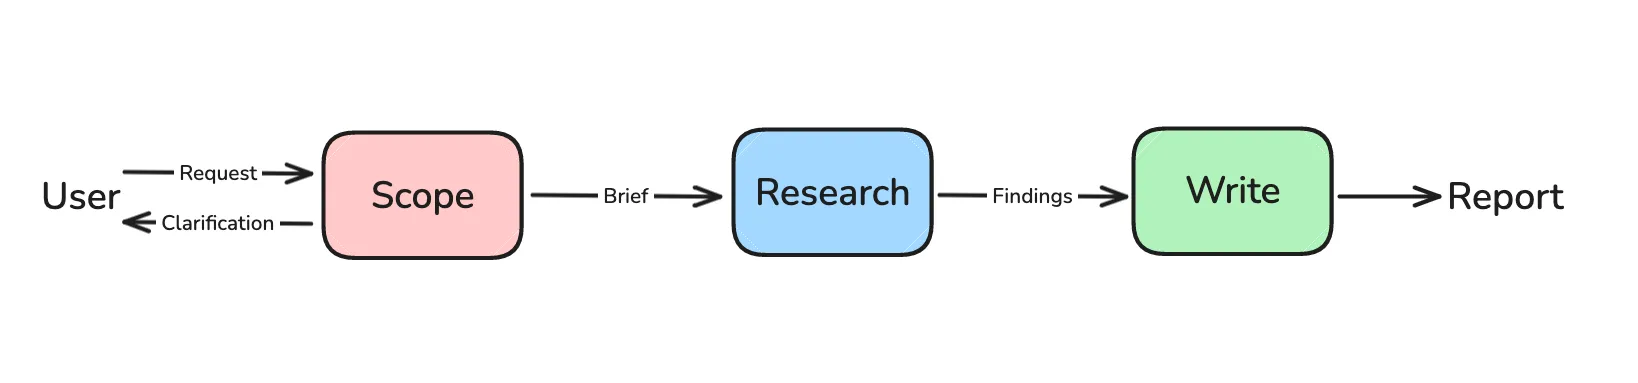

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

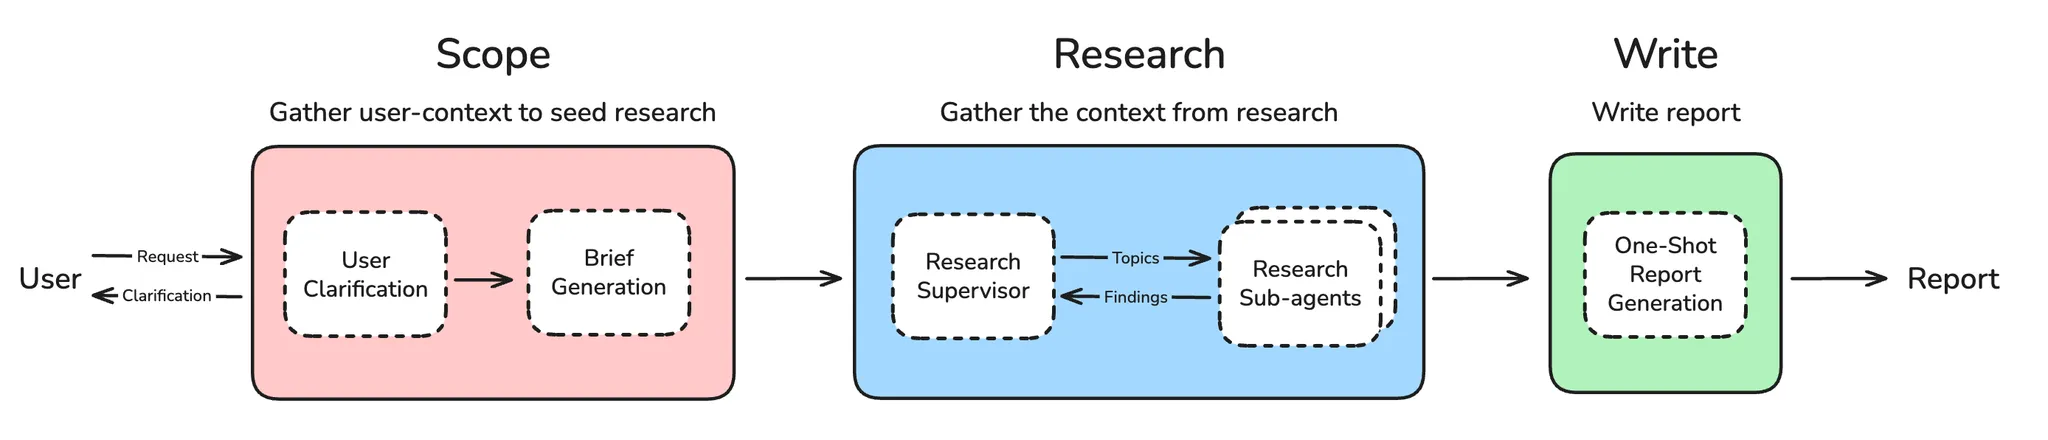

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI
writer_model = ChatGoogleGenerativeAI(model="gemini-2.5-pro", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


E0000 00:00:1761831786.346208  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761831786.353706  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761831786.358651  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761831786.361830  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761831786.362522  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761831786.368025  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761831786.373760  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


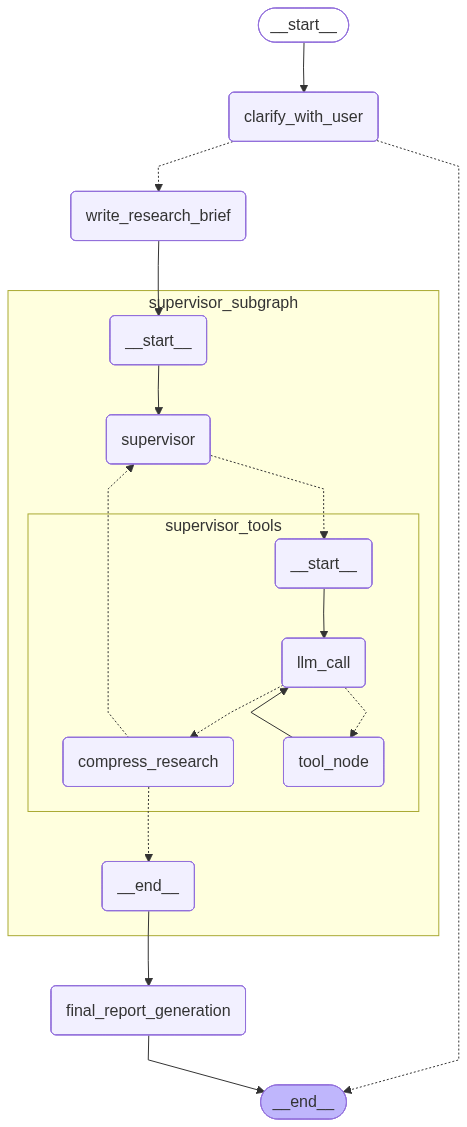

In [3]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [4]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 5}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

E0000 00:00:1761831995.207319  924457 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 32.544404915s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for your request. I will now proceed with researching and comparing Gemini to OpenAI Deep Research    │
│ agents.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # A Comparative Analysis of Gemini and OpenAI Deep Research Agents                    │
│                                                                                                                 │
│ Deep Research has emerged as a transformative paradigm for knowledge work, utilizing autonomous AI agents to    │
│ perform complex, multi-step research tasks. These agents are designed to go beyond simple search queries by     │
│ conducting large-scale information retrieval across numerous sources, aggregating evidence, and synthesizing    │
│ findings into structured, research-grade reports with citations [1, 2]. As of 2025, two of the most prominent   │
│ players in this space are Google, with its Gemini Deep Research agents, and OpenAI. This report provides a      │
│ comprehensive comparison of these two offerings across their key capabilities, performance, and underlying      │
│ architectures.                                                                                                  │
│                                                                                                                 │
│ ## Gemini Deep Research Agents                                                                                  │
│                                                                                                                 │
│ Integrated into the Gemini ecosystem, Google's Deep Research is an agentic feature designed to function as a    │
│ personal research assistant. It leverages the Gemini 2.5 model to automate the entire research process, from    │
│ planning to the generation of insightful, multi-page reports [3].                                               │
│                                                                                                                 │
│ ### Key Capabilities                                                                                            │
│                                                                                                                 │
│ Gemini's Deep Research agents are equipped with a range of capabilities aimed at creating a comprehensive and   │
│ collaborative research experience:                                                                              │
│                                                                                                                 │
│ *   **End-to-End Workflow Automation:** The agent can take a user's prompt and independently transform it into  │
│ a multi-point research plan. It then autonomously browses up to hundreds of websites to gather information,     │
│ delivering a detailed custom report in minutes [3].                                                             │
│ *   **Intelligent Knowledge Discovery:** The system is designed to autonomously search and deeply browse the    │
│ web to find the most relevant and up-to-date information for a given task [3].                                  │
│ *   **Collaborative Intelligence:** Gemini aims to be a collaborative partner rather than just a                │
│ question-answering tool. It shows its thought process as it reasons over gathered information, allowing users   │
│ to understand its next move [3].                                                                                │
│ *   **Multimedia and Interactive Outputs:** Reports can be converted into **Audio Overviews**, allowing users   │
│ to listen to summaries and save time. They can also be transformed into interactive content like quizzes        │
│ through integration with Canvas [3].                                                                            │
│ *   **User-Guided Research:** Users can upload their own files to the agent, providing specific context or data │
│ to guide and focus the research process [3].           

In [4]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [5]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for your request. I will now proceed with researching and comparing Gemini to OpenAI Deep Research    │
│ agents.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # A Comparative Analysis of Gemini and OpenAI Deep Research Agents                    │
│                                                                                                                 │
│ Deep Research has emerged as a transformative paradigm for knowledge work, utilizing autonomous AI agents to    │
│ perform complex, multi-step research tasks. These agents are designed to go beyond simple search queries by     │
│ conducting large-scale information retrieval across numerous sources, aggregating evidence, and synthesizing    │
│ findings into structured, research-grade reports with citations [1, 2]. As of 2025, two of the most prominent   │
│ players in this space are Google, with its Gemini Deep Research agents, and OpenAI. This report provides a      │
│ comprehensive comparison of these two offerings across their key capabilities, performance, and underlying      │
│ architectures.                                                                                                  │
│                                                                                                                 │
│ ## Gemini Deep Research Agents                                                                                  │
│                                                                                                                 │
│ Integrated into the Gemini ecosystem, Google's Deep Research is an agentic feature designed to function as a    │
│ personal research assistant. It leverages the Gemini 2.5 model to automate the entire research process, from    │
│ planning to the generation of insightful, multi-page reports [3].                                               │
│                                                                                                                 │
│ ### Key Capabilities                                                                                            │
│                                                                                                                 │
│ Gemini's Deep Research agents are equipped with a range of capabilities aimed at creating a comprehensive and   │
│ collaborative research experience:                                                                              │
│                                                                                                                 │
│ *   **End-to-End Workflow Automation:** The agent can take a user's prompt and independently transform it into  │
│ a multi-point research plan. It then autonomously browses up to hundreds of websites to gather information,     │
│ delivering a detailed custom report in minutes [3].                                                             │
│ *   **Intelligent Knowledge Discovery:** The system is designed to autonomously search and deeply browse the    │
│ web to find the most relevant and up-to-date information for a given task [3].                                  │
│ *   **Collaborative Intelligence:** Gemini aims to be a collaborative partner rather than just a                │
│ question-answering tool. It shows its thought process as it reasons over gathered information, allowing users   │
│ to understand its next move [3].                                                                                │
│ *   **Multimedia and Interactive Outputs:** Reports can be converted into **Audio Overviews**, allowing users   │
│ to listen to summaries and save time. They can also be transformed into interactive content like quizzes        │
│ through integration with Canvas [3].                                                                            │
│ *   **User-Guided Research:** Users can upload their own files to the agent, providing specific context or data │
│ to guide and focus the research process [3].           

In [6]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                        A Comparative Analysis of Gemini and OpenAI Deep Research Agents                         ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Deep Research has emerged as a transformative paradigm for knowledge work, utilizing autonomous AI agents to       
perform complex, multi-step research tasks. These agents are designed to go beyond simple search queries by        
conducting large-scale information retrieval across numerous sources, aggregating evidence, and synthesizing       
findings into structured, research-grade reports with citations [1, 2]. As of 2025, two of the most prominent      
players in this space are Google, with its Gemini Deep Research agents, and OpenAI. This report provides a         
comprehensive comparison of these two offerings across their key capabilities, performance, and underlying         
architectures.                                                                                                     


                                            Gemini Deep Research Agents                                            

Integrated into the Gemini ecosystem, Google's Deep Research is an agentic feature designed to function as a       
personal research assistant. It leverages the Gemini 2.5 model to automate the entire research process, from       
planning to the generation of insightful, multi-page reports [3].                                                  

                                                 Key Capabilities                                                  

Gemini's Deep Research agents are equipped with a range of capabilities aimed at creating a comprehensive and      
collaborative research experience:                                                                                 

 • End-to-End Workflow Automation: The agent can take a user's prompt and independently transform it into a        
   multi-point research plan. It then autonomously browses up to hundreds of websites to gather information,       
   delivering a detailed custom report in minutes [3].                                                             
 • Intelligent Knowledge Discovery: The system is designed to autonomously search and deeply browse the web to find
   the most relevant and up-to-date information for a given task [3].                                              
 • Collaborative Intelligence: Gemini aims to be a collaborative partner rather than just a question-answering     
   tool. It shows its thought process as it reasons over gathered information, allowing users to understand its    
   next move [3].                                                                                                  
 • Multimedia and Interactive Outputs: Reports can be converted into Audio Overviews, allowing users to listen to  
   summaries and save time. They can also be transformed into interactive content like quizzes through integration 
   with Canvas [3].                                                                                                
 • User-Guided Research: Users can upload their own files to the agent, providing specific context or data to guide
   and focus the research process [3].                                                                             
 • Broad Accessibility: The feature is available on both desktop and mobile platforms across 150 countries and in  
   over 45 languages, with specific availability for Google Workspace users [3].                                   

                                                    Performance                                                    

While specific quantitative benchmarks are not provided in the research, Gemini's performance is characterized by  
several key attributes:                        

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```